Importing Important Libraries

In [20]:
import numpy as np
import time
import matplotlib.pyplot as plt

2.1 DIRECT METHODS
2.1.1 Exact solution & source term


In [21]:

# For sparse operations
from scipy.sparse import diags, eye, kron
from scipy.sparse.linalg import spsolve

def u_exact_soln(x, y): # u_exact_soln(x,y) = sin(pi*x)*sin(pi*y)
  
    return np.sin(np.pi*x)*np.sin(np.pi*y)

def f_source(x, y):     # f_source(x,y) =Delta u = -2*pi^2*sin(pi*x)*sin(pi*y)
    
    return 2.0*(np.pi**2)*np.sin(np.pi*x)*np.sin(np.pi*y)

2.1.2 Build 1D Laplacian (Dirichlet)


In [22]:
def create_1d_laplacian(N, h): # Build (N-1)x(N-1) 1D Laplacian with Dirichlet Boundary Conditions.. h = 1.0/N
    main_val =  2.0/(h*h)       # Got this by Taylor series expansion.
    off_val  = -1.0/(h*h)
    main_diag = main_val * np.ones(N-1)     # It creates (N-1) main diagonal elements
    off_diag  = off_val  * np.ones(N-2)     # It creates (N-2) off diagonal elements, representing the subdiagonal and superdiagonal.

    T = diags(                              # It creates a sparse matrix in CSC format (CSC = Compressed Sparse Column)
        [off_diag, main_diag, off_diag],
        offsets=[-1, 0, 1],
        shape=(N-1, N-1),                   # It defines the shape of the matrix
        format='csc'                       # It is creating a compressed sparse column (CSC) format, which is memory-efficient and optimized for solving linear systems.
                                            #Only stores non zero elements..
    )
    return T                            # Returning the 1D Laplacian matrix, The matrix for the internal points (excluding boundary points)..

2.1.3 Build 2D Laplacian using Kronecker

In [23]:

def create_2d_laplacian_sparse(Nx, Ny, dx, dy):
    """
    Here we r building the (Nx-1)*(Ny-1) x (Nx-1)*(Ny-1) Laplacian matrix
    (Dirichlet) via Kronecker products:
       A = (I_y ⨂ T_x) + (T_y ⨂ I_x). (IMPORTANT)     #I_y ⨂ T_x handles the x direction deri and T_y ⨂ I_x handles the y direction derivatives..
    """
    T_x = create_1d_laplacian(Nx, dx)    # It creates the 1D Laplacian matrix foe x direction
    T_y = create_1d_laplacian(Ny, dy)   # It creates the 1D Laplacian matrix for y direction
    Ix = eye(Nx-1, format='csc')    # It creates the identity matrix for x direction
    Iy = eye(Ny-1, format='csc')    # It creates the identity matrix for y direction
    return kron(Iy, T_x, format='csc') + kron(T_y, Ix, format='csc')       # It returns the 2D Laplacian matrix by taking the Kronecker product of the 1D Laplacian matrices in x and y directions.


2.1.4 Build the RHS vector

In [24]:
def compute_rhs(Nx, Ny, dx, dy, f_func):    # It returns the RHS vector of length (Nx-1)*(Ny-1), evaluating f at each interior point (i,j).
 
    b = np.zeros((Nx-1)*(Ny-1))             # It creates a 1D vector b of length (Nx-1)*(Ny-1). (with all zeros)

    def idx(i, j):                          # This converts a 2D grid index (i,j) to a 1D index in the vector b.
        return j*(Nx-1) + i                 # The row index is j and the column index is i.. The 1D index is computed as: j*(Nx-1) + i.

    for j in range(1, Ny):              # Here we are looping through the interior points (i,j) (Exc the boundary points)
        yj = j*dy                       # Position along y-axis
        for i in range(1, Nx):
            xi = i*dx                   # Position along x-axis
            row = idx(i-1, j-1)       # Convert (i, j) to 1D index
            b[row] = f_func(xi, yj)     
    return b

'''
Reason behind skipping the boundary condn is that the Poisson equation is solved only for interior points..
Also, Boundary values are fixed by Dirichlet conditions, so they are not included in b.
And that's why the loop starts from 1 and ends at N-1 {Not Including Nx and Ny}  :)
'''

"\nReason behind skipping the boundary condn is that the Poisson equation is solved only for interior points..\nAlso, Boundary values are fixed by Dirichlet conditions, so they are not included in b.\nAnd that's why the loop starts from 1 and ends at N-1 {Not Including Nx and Ny}  :)\n"

2.1.5 Direct solve (Sparse vs. Dense)

In [25]:
def solve_poisson_sparse(Nx, Ny, f_func):                   # Uses a sparse matrix and spsolve(), which is memory-efficient.
    dx = 1.0/Nx
    dy = 1.0/Ny 
    A_sparse = create_2d_laplacian_sparse(Nx, Ny, dx, dy)   # Construct the Sparse 2D Laplacian Matrix
    b = compute_rhs(Nx, Ny, dx, dy, f_func)                 # Calls compute_rhs(), which evaluates the source function f(x,y) at interior grid points. 
                                                            # This forms the right-hand side (RHS) vector in the equation: A u = b.
    u_vec = spsolve(A_sparse, b)                            # Solves the linear system A u = b using the sparse solver spsolve(). 
                                                            # This is much faster and more memory-efficient than using dense solvers.

    U = np.reshape(u_vec, (Ny-1, Nx-1))                     # Reshapes the solution vector u_vec into a 2D grid U of shape (Ny-1) x (Nx-1).
    return U

def solve_poisson_dense(Nx, Ny, f_func):                    # This function solves the Poisson equation using a full (dense) matrix, which is slow for large grids. (Old Method)
   
    dx = 1.0 / Nx
    dy = 1.0 / Ny
    Nint = (Nx-1)*(Ny-1)                                # Creates a full (dense) matrix of size (Nx-1)*(Ny-1) x (Nx-1)*(Ny-1).
                                                        # This matrix represents the 2D Laplacian operator.

    A_dense = np.zeros((Nint, Nint))                    # Filled with zeros initially.

    def idx(i, j):                                      # This function converts a 2D grid index (i,j) to a 1D index in the matrix A_dense.
        return j*(Nx-1) + i

    Cx = 1.0/(dx*dx)
    Cy = 1.0/(dy*dy)
    main_diag = 2*(Cx + Cy)                    # The main diagonal element of the 2D Laplacian matrix is 2*(Cx + Cy).

    for j in range(Ny-1):
        for i in range(Nx-1):
            row = idx(i, j)
            A_dense[row, row] = main_diag
            if i > 0:       A_dense[row, idx(i-1, j)]   = -Cx
            if i < Nx-2:    A_dense[row, idx(i+1, j)]   = -Cx
            if j > 0:       A_dense[row, idx(i, j-1)]   = -Cy
            if j < Ny-2:    A_dense[row, idx(i, j+1)]   = -Cy

    b = compute_rhs(Nx, Ny, dx, dy, f_func)                 # Computes the RHS vector just like in the sparse solver.
    u_vec = np.linalg.solve(A_dense, b)
    U = np.reshape(u_vec, (Ny-1, Nx-1))
    return U


2.2 ITERATIVE METHODS
2.2.1 Implement Jacobi & Gauss–Seidel



Jacobi Method:- 
1) Convergence :- Slower
2) Memory Use :- More memory (needs old vector)
3) Best for	Large systems with parallel execution

Gauss Seidel Method:-
1) Convergence :- Faster 
2) Memory Use :- Less memory (overwrites old values)
3) Faster sequential convergence

In [26]:
def jacobi_method(A, b, max_iter=5000, tol=1e-8):  # The Jacobi method iteratively updates the solution without modifying previous values. The equation: A x = b is solved for x.
                                                     # Ax = b can be rewritten as x^{k+1} = D^{-1}(b - R x^k), where A = D + R.
    n = len(b)
    x = np.zeros_like(b)  # Initial guess (zero vector)
    D = np.diag(A)        # D = Diag part of A, which is a diagonal matrix. (D^{-1} is the inverse of the diagonal matrix D.)
    R = A - np.diagflat(D)  # R=A - D contains the off-diagonal elements.
    
    residual_history = []
    
    for k in range(max_iter):
        x_new = (b - np.dot(R, x)) / D  # Jacobi update step
        residual = np.linalg.norm(x_new - x, ord=np.inf)  # Check max difference
        
        residual_history.append(residual)
        
        if residual < tol:  # Convergence check
            return x_new, k, residual_history
        
        x = x_new  # Update solution

    return x, max_iter, residual_history  # Return max_iter if not converged

# ----------------------------------==-===---------------------------------------------------------------------------------------===-------

def gauss_seidel_method(A, b, max_iter=5000, tol=1e-8): # The Gauss-Seidel method updates the solution by using the most recent values. The equation: A x = b is solved for x.
    """
    Implements Gauss-Seidel iteration:
        x[i]^(k+1) = (1/A_ii) * ( b_i - sum_{j<i} A_ij * x[j]^(k+1) - sum_{j>i} A_ij * x[j]^(k) )
    Returns: x (solution), iteration count, residual history.
    """
    n = len(b)
    x = np.zeros_like(b)  # Initial guess
    residual_history = []

    for k in range(max_iter):
        x_old = np.copy(x)  # Store previous iteration
        
        for i in range(n):
            sum1 = np.dot(A[i, :i], x[:i])    # Contribution from already updated values
            sum2 = np.dot(A[i, i+1:], x_old[i+1:])  # Contribution from old values
            x[i] = (b[i] - sum1 - sum2) / A[i, i]  # Update step

        residual = np.linalg.norm(x - x_old, ord=np.inf)  # Check max difference
        residual_history.append(residual)

        if residual < tol:  # Convergence check
            return x, k, residual_history

    return x, max_iter, residual_history  # Return max_iter if not converged


2.2.2 Convergence discussion (theoretical, no code here)
I have added this in PPT why Jacobi/G–S converge..

2.2.3 Measuring cost (# iterations & cost/iteration)
Again, I have added this in PPT that how to count flops or measure iteration time.

2.2.4 Implement SOR method

In [94]:
import numpy as np

def sor_method(A, b, omega=1.5, max_iter=5000, tol=1e-8):
    """
    Successive Over-Relaxation (SOR) method for solving Ax = b.

    Parameters:
        A (numpy.ndarray): Coefficient matrix (NxN)
        b (numpy.ndarray): Right-hand side vector (Nx1)
        omega (float): Relaxation factor (1.0 = Gauss-Seidel, typically 1.1 to 1.8 for SOR)
        max_iter (int): Maximum number of iterations
        tol (float): Convergence tolerance

    Returningg:
        x (numpy.ndarray): Approximate solution vector
        iteration_count (int): Number of iterations before convergence
        residual_history (list): Residual norms at each iteration
    """
    n = len(b)
    x = np.zeros_like(b, dtype=float)  # Initial guess
    residual_history = []

    # Check if the matrix is ill-conditioned
    cond_number = np.linalg.cond(A)
    if cond_number > 1e10:
        print(f"Warning: The matrix is ill-conditioned (Condition Number = {cond_number:.2e}).")

    for k in range(max_iter):
        x_old = np.copy(x)  # Store previous iteration
        
        for i in range(n):
            if abs(A[i, i]) < 1e-10:  # Prevent division by very small values
                raise ValueError(f"Zero or near-zero diagonal element detected at index {i}: A[{i}, {i}] = {A[i, i]}")

            sum1 = np.dot(A[i, :i], x[:i])      # Contribution from already updated values
            sum2 = np.dot(A[i, i+1:], x_old[i+1:])  # Contribution from old values

            update = (omega / A[i, i]) * (b[i] - sum1 - sum2)  # Compute update
            x[i] = np.clip(x_old[i] + update, -1e10, 1e10)  # Prevent overflow

        # Compute residual and check for convergence
        residual = np.linalg.norm(x - x_old, ord=np.inf)
        residual_history.append(residual)

        if residual < tol:  # Convergence check
            return x, k + 1, residual_history  # Return when solution converges

    print("Warning: Maximum iterations reached without full convergence.")
    return x, max_iter, residual_history  # If max_iter is reached, return last solution




# def sor_method(A, b, omega=1.0, max_iter=5000, tol=1e-8):
#     """
#     Successive Over-Relaxation (SOR) iteration:
#       x[i]^{k+1} = x[i]^k + omega/a_{ii} *
#         ( b[i] - sum_{j< i} a_{ij} x[j]^{k+1}
#                 - sum_{j>=i} a_{ij} x[j]^{k} )
#     Return: x, iteration_count, residual_history
#     """
#     # Placeholder skeleton
#     import numpy as np
#     x = np.zeros_like(b)
#     # ...
#     return x, 0, []


2.2.5 Plotting residual decreases, etc.


In [95]:

def plot_residuals(res_jacobi, res_gs, res_sor): # Plots the residual history of the Jacobi, Gauss-Seidel, and SOR methods.
   
    plt.figure()
    plt.semilogy(res_jacobi, label='Jacobi')
    plt.semilogy(res_gs,     label='Gauss-Seidel')
    plt.semilogy(res_sor,    label='SOR')
    plt.xlabel("Iteration")
    plt.ylabel("Residual norm (log scale)")
    plt.legend()
    plt.show()


Grid: 50 x 50, Interior Size = 2401
  Sparse Solver Time: 0.010 s
  Dense  Solver Time: 0.125 s
  Max Difference (Sparse-Dense) = 5.995204e-15

Grid: 100 x 100, Interior Size = 9801
  Sparse Solver Time: 0.038 s
  Dense  Solver Time: 3.202 s
  Max Difference (Sparse-Dense) = 9.658940e-15


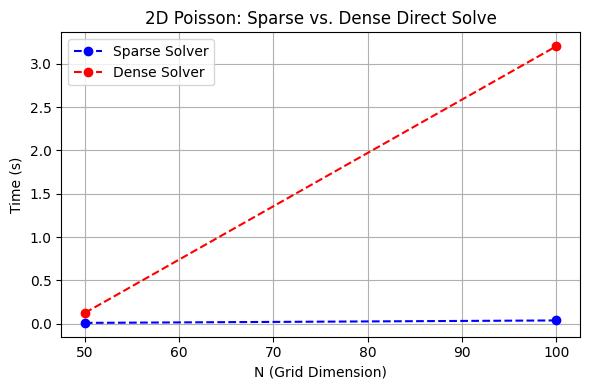


Jacobi finished in 1133 iterations.
Gauss-Seidel finished in 595 iterations.
SOR(omega=1.5) finished in 28 iterations.


In [96]:
# MAIN / DRIVER CODE

if __name__=="__main__":

    # 2.1 DIRECT METHODS: Dense vs. Sparse
    sizes = [50, 100]  # Adjust as needed
    times_sparse = []
    times_dense  = []

    for N in sizes:
        print(f"\nGrid: {N} x {N}, Interior Size = {(N-1)*(N-1)}") # Print grid size

        #--- Sparse solve ---
        t0 = time.time()                            # Start the timer
        U_sp = solve_poisson_sparse(N, N, f_source) # Solve the Poisson equation using the sparse solver
        t1 = time.time()                    # Stop the timer                    
        t_sp = t1 - t0                    # Compute the time taken
        times_sparse.append(t_sp)      # Store the time taken

        #--- Dense solve ---
        t0 = time.time()                            # Start the timer
        U_dn = solve_poisson_dense(N, N, f_source)  # Solve the Poisson equation using the dense solver
        t1 = time.time()                # Stop the timer
        t_dn = t1 - t0              # Compute the time taken
        times_dense.append(t_dn)    # Store the time taken

        # Print times
        print(f"  Sparse Solver Time: {t_sp:.3f} s")
        print(f"  Dense  Solver Time: {t_dn:.3f} s")

        # Check difference
        diff = np.max(np.abs(U_sp - U_dn))                      # Compute the maximum difference between the sparse and dense solutions.
        print(f"  Max Difference (Sparse-Dense) = {diff:e}")

    # Plot timing comparison (dense vs. sparse) 
    plt.figure(figsize=(6,4))
    plt.plot(sizes, times_sparse, 'o--', label='Sparse Solver', color='blue')
    plt.plot(sizes, times_dense,  'o--', label='Dense Solver',  color='red')
    plt.xlabel("N (Grid Dimension)")
    plt.ylabel("Time (s)")
    plt.title("2D Poisson: Sparse vs. Dense Direct Solve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2.2 ITERATIVE METHODS DEMO (Placeholders)
    # Eg:- Lets build a small system and solve with Jacobi, GS, SOR:
    N_test = 20
    dx = 1.0 / N_test
    dy = 1.0 / N_test
    A_test = create_2d_laplacian_sparse(N_test, N_test, dx, dy)         # Create a small 2D Laplacian matrix
    b_test = compute_rhs(N_test, N_test, dx, dy, f_source)              # Compute the RHS vector

    A_test_dense = A_test.toarray()                 # Convert to dense matrix for iterative methods

    # Jacobi 
    x_jac, it_jac, res_jac = jacobi_method(A_test_dense, b_test)
    print(f"\nJacobi finished in {it_jac} iterations.")

    # Gauss-Seidel
    x_gs, it_gs, res_gs = gauss_seidel_method(A_test_dense, b_test)
    print(f"Gauss-Seidel finished in {it_gs} iterations.")

    # SOR (with optimal omega)
    omega = 1.5  # Example guess
    x_sor, it_sor, res_sor = sor_method(A_test_dense, b_test, omega=omega)      # Solve with SOR
    print(f"SOR(omega={omega}) finished in {it_sor} iterations.") # Print iteration counts
